# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [6]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy, r_squared, mse, mae

# Доп модули
from sklearn.neighbors import KNeighborsClassifier


In [7]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
# Выбор случайных 1000 наблюдений
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

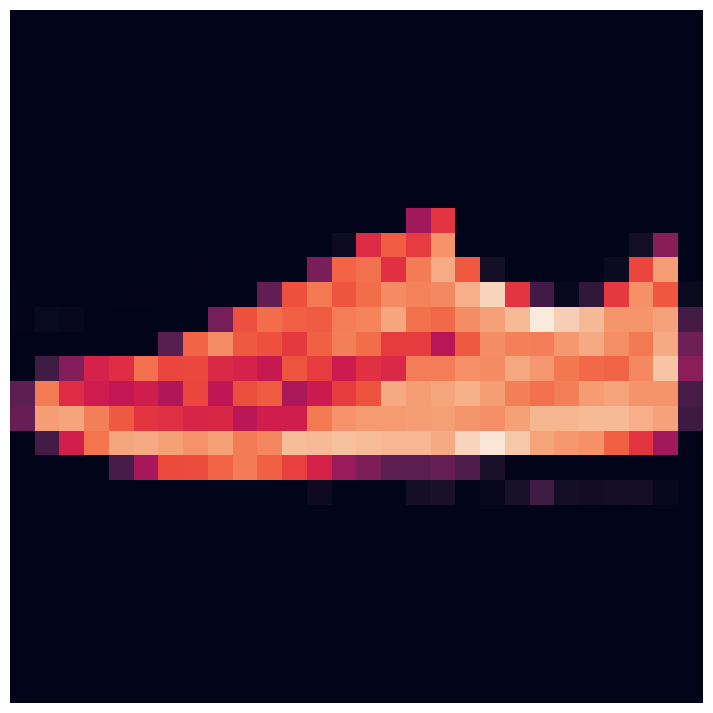

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

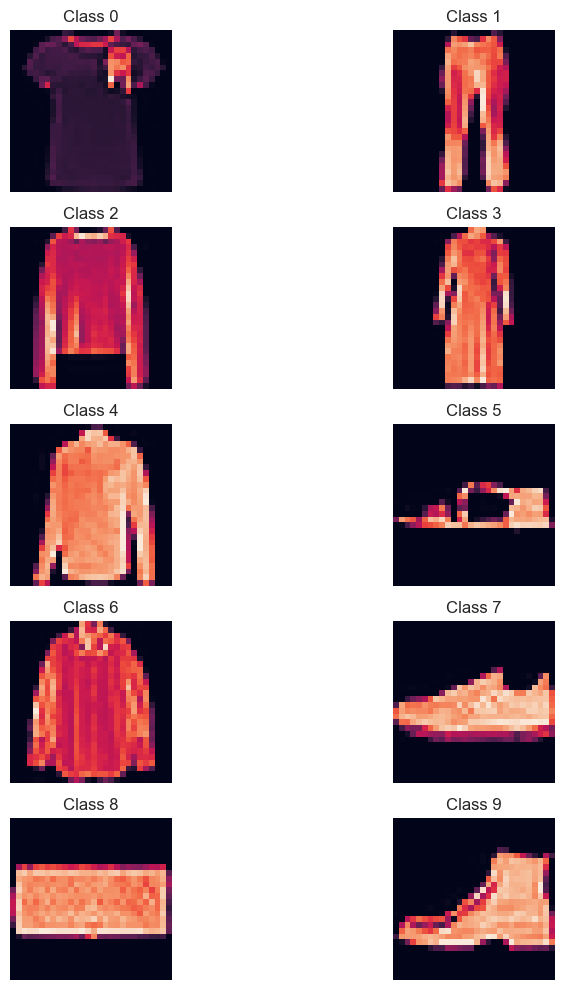

In [6]:
# Определим уникальные классы в выборке, которые представляют разные виды одежды
classes = np.unique(y)
class_images = []

for c in classes:
    # Находим индекс первой картинки для каждого класса
    idx = np.where(y == c)[0][0]
    class_images.append(X[idx].reshape(28, 28, 1))

# Отобразим картинки в виде сетки 5 на 2
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    plt.subplot(5, 2, i+1)
    plt.imshow(class_images[i])
    plt.title(f'Class {classes[i]}')
    plt.axis("off")
plt.tight_layout()
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

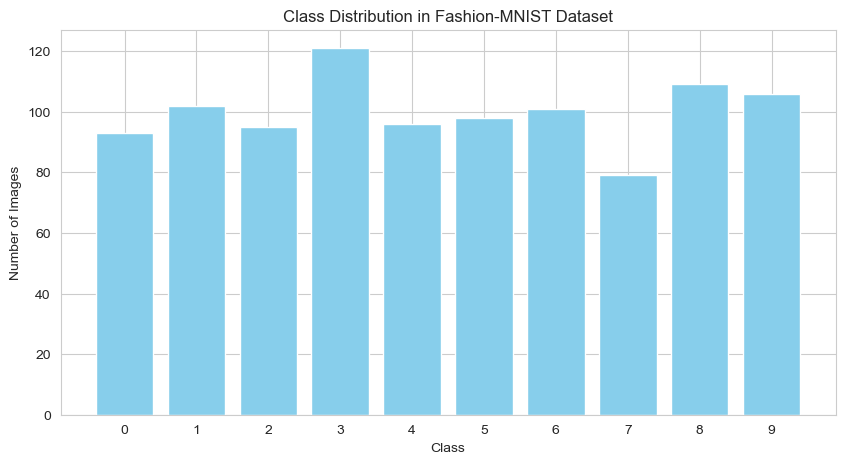

In [7]:
y = y.astype(int)
class_counts = np.bincount(y)
plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts, color='skyblue')
plt.xticks(range(len(class_counts)), labels=range(10))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Fashion-MNIST Dataset')
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [9]:
train_mask = (y_train == 0) | (y_train == 1)
binary_train_X = X_train[train_mask]
binary_train_y = y_train[train_mask]

test_mask = (y_test == 0) | (y_test == 1)
binary_test_X = X_test[test_mask]
binary_test_y = y_test[test_mask]

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [10]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [11]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [12]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [14]:
# Второй метод наиболее эффективен
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

158 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.3 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
68.9 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [15]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [16]:
prediction == binary_test_y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [17]:
# TODO: binary_classification_metrics in metrics.py

In [17]:
# precision, recall, f1, accuracy
binary_classification_metrics(prediction, binary_test_y)

(1.0, 1.0, 1.0, 1.0)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision = precision_score(binary_test_y, prediction)
recall = recall_score(binary_test_y, prediction)
f1 = f1_score(binary_test_y, prediction)
accuracy = accuracy_score(binary_test_y, prediction)
print(precision, recall, f1, accuracy)

1.0 1.0 1.0 1.0


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [19]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    
    train_metrics = []
    test_metrics = []
    for k in params:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        y_train_pred = knn.predict(X_train)
        train_metric = metric(y_train, y_train_pred)
        train_metrics.append(train_metric)
        
        y_test_pred = knn.predict(X_test)
        test_metric = metric(y_test, y_test_pred)
        test_metrics.append(test_metric)
    
    return train_metrics, test_metrics
    

In [20]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

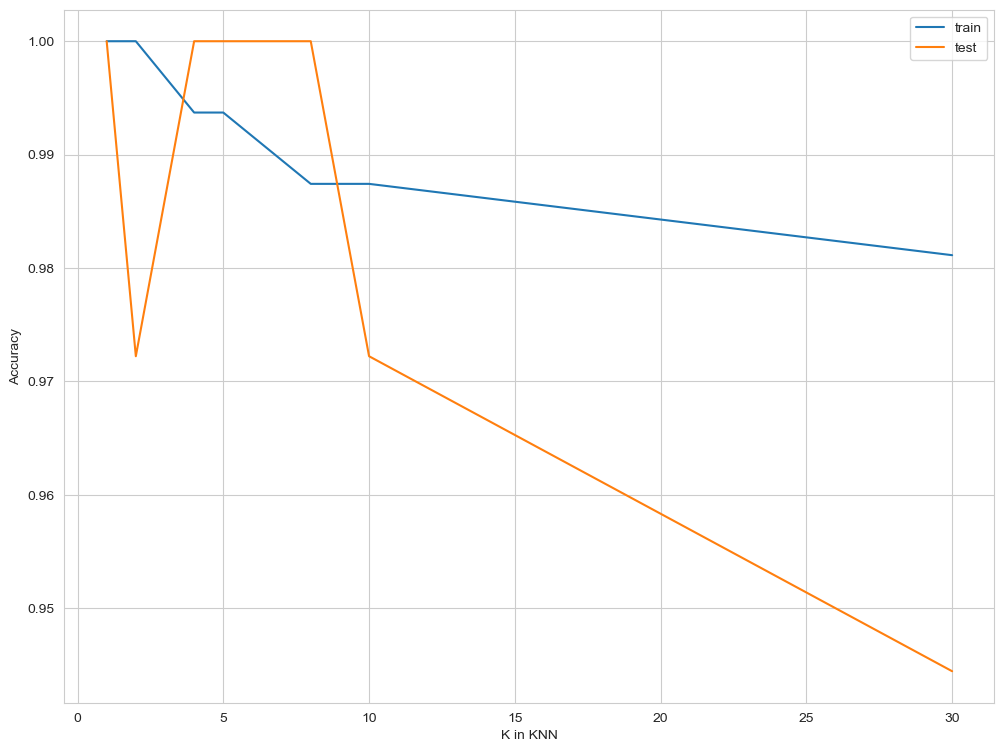

In [21]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

По графику видно, что наиболее оптимальным значением K яляется 1. 

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [22]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [23]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.77

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

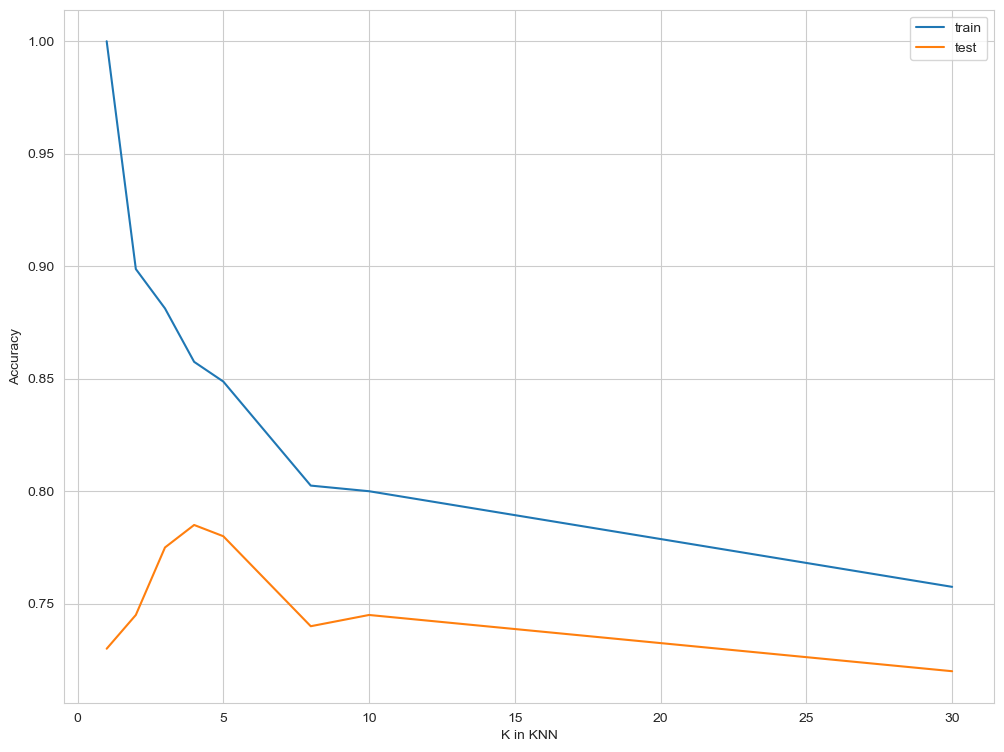

In [24]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    train_metrics = []
    test_metrics = []
    for k in params:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        y_train_pred = knn.predict(X_train)
        train_metric = metric(y_train, y_train_pred)
        train_metrics.append(train_metric)
        
        y_test_pred = knn.predict(X_test)
        test_metric = metric(y_test, y_test_pred)
        test_metrics.append(test_metric)
    
    return train_metrics, test_metrics

params = [1, 2, 3, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test , params, multiclass_accuracy)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");


In [25]:
# Выбираем оптимальное значение K
best_k_index = test_metrics.index(max(test_metrics))
best_k = params[best_k_index]
print("Best value of k:", best_k)

Best value of k: 4


## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [10]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor

In [11]:
X, y = load_diabetes(as_frame=True, return_X_y=True,  scaled=False)

In [12]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


In [13]:
# Колонка sex является категориальной
X['sex'].unique()

array([2., 1.])

### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [14]:
from sklearn.pipeline import Pipeline
print(X.describe())

              age         sex         bmi          bp          s1          s2  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    48.518100    1.468326   26.375792   94.647014  189.140271  115.439140   
std     13.109028    0.499561    4.418122   13.831283   34.608052   30.413081   
min     19.000000    1.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    1.000000   23.200000   84.000000  164.250000   96.050000   
50%     50.000000    1.000000   25.700000   93.000000  186.000000  113.000000   
75%     59.000000    2.000000   29.275000  105.000000  209.750000  134.500000   
max     79.000000    2.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6  
count  442.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.070249    4.641411   91.260181  
std     12.934202    1.290450    0.522391   11.496335  
min     22.000000    2.000000    3.258100   58

In [15]:
# Распределение целевой переменной
print(y.describe())

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64


In [16]:
# Проверим наличие пропущенных значений
print(X.isnull().sum())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


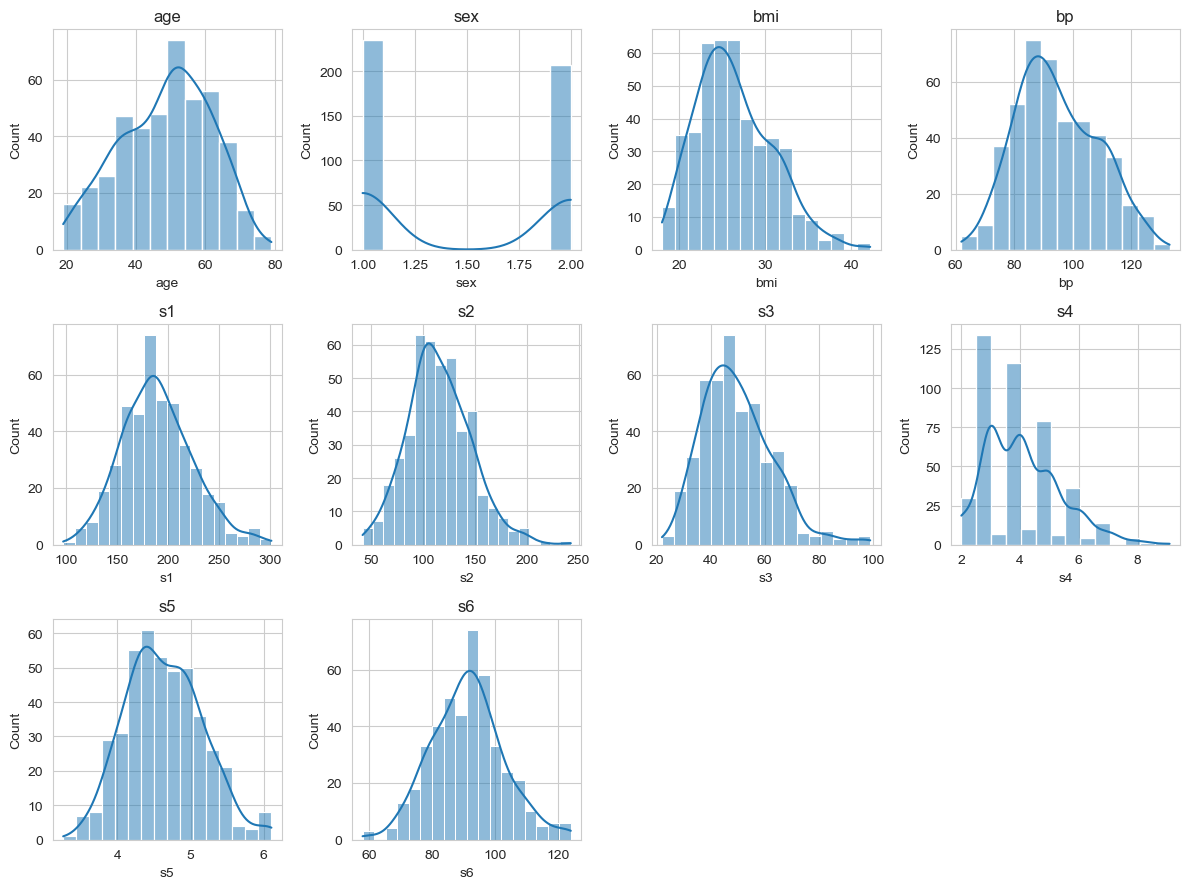

In [26]:
# Создаем гистограммы для каждого признака
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(X[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

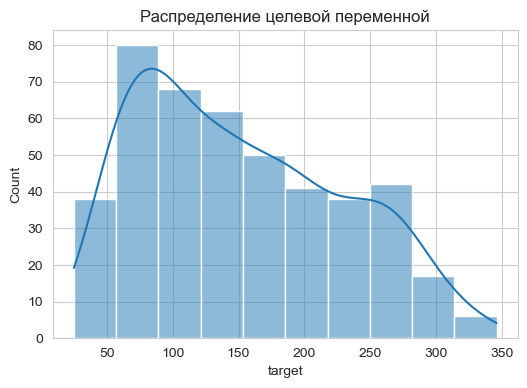

In [17]:
# Гистограмма для целевой переменной (ненормальное распределение)
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title('Распределение целевой переменной')
plt.show()

In [18]:
# Создаем пайплайн
# K=17
from sklearn.compose import ColumnTransformer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

k_neighbors = [1, 2, 3, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
r2_scores = []
mse_scores = []
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns.drop('sex')),
        ('cat', OneHotEncoder(), ['sex'])
    ])

for k in k_neighbors:
    knn_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("knn", KNeighborsRegressor(n_neighbors=k, n_jobs=8))
        ])
    knn_pipeline.fit(X_train, y_train)
    y_test_pred = knn_pipeline.predict(X_test)
    r2 = r2_score(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    
    r2_scores += [r2]
    mse_scores += [mse]
    
    print(k, r2, mse)

1 -0.06364025176246457 4999.5842696629215
2 0.20552494050988823 3734.387640449438
3 0.2738772780728358 3413.1011235955057
5 0.3423519563879024 3091.239550561798
7 0.3981547920807724 2828.941297867462
10 0.44213145312403723 2622.231348314607
11 0.4271809609352941 2692.5053394001297
12 0.4457596670361016 2605.1771223470664
13 0.4497429826601015 2586.4537597234225
14 0.4405545154558953 2629.6436597110755
15 0.44654130577198536 2601.5030711610493
16 0.4434613011184354 2615.98046875
17 0.4557272343180412 2558.3251040006216
18 0.44899054190751 2589.9905673463727
19 0.436990043614333 2646.398269476174
20 0.43649174883067743 2648.7404775280897


### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [19]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=17))
])

# Обучение модели на тренировочных данных
pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = pipeline.predict(X_test)

y_pred

array([183.52941176, 112.58823529, 154.64705882, 159.05882353,
       198.47058824, 199.41176471, 120.41176471,  99.76470588,
       105.64705882, 111.17647059, 137.88235294, 227.05882353,
       206.82352941, 215.47058824, 192.88235294, 153.        ,
       190.94117647, 129.64705882, 176.41176471, 105.41176471,
       105.52941176, 144.94117647, 136.58823529, 204.70588235,
        89.41176471, 123.52941176,  93.17647059, 118.35294118,
       192.17647059, 133.11764706, 165.17647059, 143.35294118,
       183.29411765, 163.        , 159.82352941, 120.29411765,
        91.76470588, 169.47058824, 137.70588235, 149.64705882,
       133.11764706, 259.64705882, 149.05882353, 159.23529412,
       141.58823529, 108.05882353, 145.05882353,  95.88235294,
       185.        , 142.52941176, 178.94117647, 174.64705882,
       228.47058824, 100.94117647, 207.64705882,  93.76470588,
       126.94117647, 191.23529412,  86.17647059,  88.76470588,
        94.58823529, 108.47058824, 191.64705882, 100.05

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [20]:
r2 = r_squared(y_pred, y_test)
print(f"R-squared: {r2}")

R-squared: 0.4557272343180412


In [ ]:
mse(y_pred, y_test)
print(f"Mean Squared Error: {mse}")

In [22]:
mae = mae(y_pred, y_test)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 41.03106411103767


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [ ]:
from metrics import r_squared, mse, mae

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

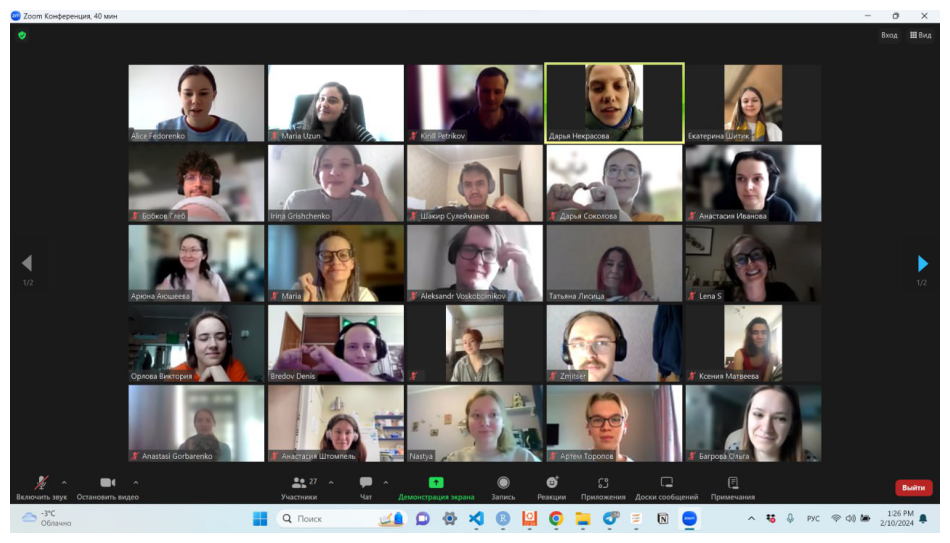

In [33]:
import matplotlib.image as mpimg
img = mpimg.imread('photozoom.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**